In [28]:
! pip install pycox

In [29]:
# !pip install pandas==1.5.3

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
df = pd.read_csv('/content/drive/MyDrive/datasets/ottok//df.csv')

In [33]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt


from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.models import PMF
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [34]:
df['employee_count_nm'] = df['employee_count_nm'].fillna('0')
encoder = LabelEncoder()
encoder = encoder.fit(df['employee_count_nm'])
df['employee_count_nm'] = encoder.transform(df['employee_count_nm'])

In [35]:
df = df.fillna(0)

In [36]:
df['target'] = df['target'].astype('float32')

In [37]:
y = df[['target', 'time']]
X = df.drop(columns= ['target', 'time'])

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [174]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1234)

In [96]:
X.columns

Index(['report', 'employee_count_nm', 'bankemplstatus', 'customer_age',
       'more_operations_out', 'operation_time_00_12', 'freq_mcc',
       'freq_currency', 'freq_weekday', 'freq_day', 'last_operation_summ',
       'last_operation_type', 'diff_report_transaction', 'last_mcc',
       'RFMScore', 'total_amount_in', 'total_amount_out'],
      dtype='object')

In [175]:
cols_standardize = ['employee_count_nm', 'customer_age','more_operations_out',
                    'operation_time_00_12', 'freq_mcc', 'freq_currency', 'freq_weekday',
                    'freq_day', 'last_operation_summ', 'last_operation_type', 'diff_report_transaction',
                    'last_mcc', 'RFMScore', 'total_amount_in', 'total_amount_out']
cols_leave = ['report', 'bankemplstatus']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [176]:
x_train = x_mapper.fit_transform(X_train).astype('float32')
x_val = x_mapper.transform(X_val).astype('float32')
x_test = x_mapper.transform(X_test).astype('float32')

In [177]:
num_durations = 30
labtrans = PMF.label_transform(num_durations)
# labtrans = LogisticHazard.label_transform(num_durations)

In [178]:
get_target = lambda df: (df['time'].values, df['target'].values)
y_train = labtrans.fit_transform(*get_target(y_train))
y_val = labtrans.transform(*get_target(y_val))

train = (x_train, y_train)
val = (x_val, y_val)
durations_test, events_test = get_target(y_test)

# val = tt.tuplefy(x_val, y_val)

In [226]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.05
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [227]:
model = PMF(net, tt.optim.Adam(0.05), duration_index=labtrans.cuts)

In [228]:
batch_size = 128
val_batch_size = 128
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
verbose = True

In [229]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.6132,	val_loss: 0.5724
1:	[0s / 1s],		train_loss: 0.5464,	val_loss: 0.5673
2:	[0s / 2s],		train_loss: 0.5465,	val_loss: 0.5642
3:	[0s / 3s],		train_loss: 0.5414,	val_loss: 0.5721
4:	[0s / 3s],		train_loss: 0.5418,	val_loss: 0.5652
5:	[0s / 4s],		train_loss: 0.5381,	val_loss: 0.5704
6:	[0s / 4s],		train_loss: 0.5373,	val_loss: 0.5614
7:	[0s / 5s],		train_loss: 0.5356,	val_loss: 0.5631
8:	[0s / 6s],		train_loss: 0.5355,	val_loss: 0.5662
9:	[0s / 6s],		train_loss: 0.5357,	val_loss: 0.5643
10:	[0s / 7s],		train_loss: 0.5340,	val_loss: 0.5616
11:	[0s / 7s],		train_loss: 0.5324,	val_loss: 0.5674
12:	[0s / 8s],		train_loss: 0.5351,	val_loss: 0.5646
13:	[0s / 9s],		train_loss: 0.5324,	val_loss: 0.5728
14:	[0s / 9s],		train_loss: 0.5320,	val_loss: 0.5773
15:	[0s / 10s],		train_loss: 0.5326,	val_loss: 0.5723
16:	[0s / 11s],		train_loss: 0.5338,	val_loss: 0.5811


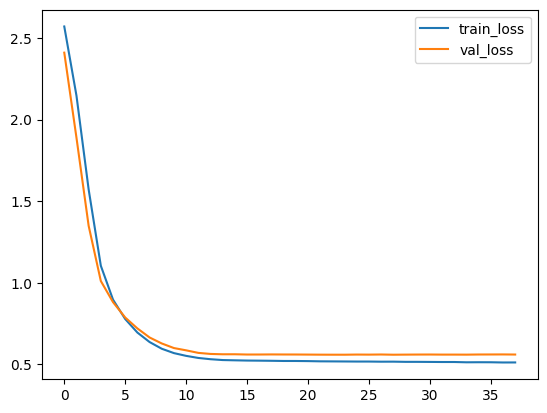

In [183]:
_ = log.plot()

In [230]:
surv = model.interpolate(10).predict_surv_df(x_test)

In [231]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


In [232]:
ev.concordance_td('antolini')

0.7043139756715265